In [ ]:
%pylab inline

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import glob
import sys

from math import *

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim
from torch.autograd import Variable
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import copy

from PIL import Image

from IPython import display
import time

import pickle

import scipy.cluster.hierarchy as sch

def tovar(x):
    return Variable(torch.FloatTensor(x).cuda(), requires_grad = False)

def toivar(x):
    return Variable(torch.LongTensor(x).cuda(), requires_grad = False)

Populating the interactive namespace from numpy and matplotlib


In [ ]:
class Embed(nn.Module):
    def __init__(self):
        super(Embed,self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,9,padding=4)
        torch.nn.init.orthogonal(self.conv1.weight)

        self.p1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32,96,3,padding=1)
        torch.nn.init.orthogonal(self.conv2.weight)
        self.conv2b = nn.Conv2d(96,48,1)
        torch.nn.init.orthogonal(self.conv2b.weight)
        self.p2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(48,128,3,padding=1)
        torch.nn.init.orthogonal(self.conv3.weight)
        self.conv3b = nn.Conv2d(128,64,1)
        torch.nn.init.orthogonal(self.conv3b.weight)        
        self.p3 = nn.MaxPool2d(2)
        
        self.conv4 = nn.Conv2d(64,96,3,padding=1)
        torch.nn.init.orthogonal(self.conv4.weight)        
        self.p4 = nn.MaxPool2d(2)
        
        self.conv5 = nn.Conv2d(96,128,3,padding=1)
        torch.nn.init.orthogonal(self.conv5.weight)        
        self.conv6 = nn.Conv2d(128,128,3,padding=1)
        torch.nn.init.orthogonal(self.conv6.weight)        
        self.p5 = nn.MaxPool2d(2)
        
        self.dense1 = nn.Linear(10*128,256)
        self.dense2 = nn.Linear(256,256)
        self.dense3 = nn.Linear(256,64)
        
    def inter(self, x):
        z = self.p1(F.elu(self.conv1(x)))
        #z = self.p2(F.elu(self.conv2b(F.elu(self.conv2(z)))))
        #z = self.p3(F.elu(self.conv3b(F.elu(self.conv3(z)))))
        #z = self.p4(F.elu(self.conv4(z)))
        
        #z = F.elu(self.conv5(z))
        #z = z + F.elu(self.conv6(z))
        
        return z

    def forward(self, x):
        z = self.p1(F.elu(self.conv1(x)))
        z = self.p2(F.elu(self.conv2b(F.elu(self.conv2(z)))))
        z = self.p3(F.elu(self.conv3b(F.elu(self.conv3(z)))))
        z = self.p4(F.elu(self.conv4(z)))
        
        z = F.elu(self.conv5(z))
        z = z + F.elu(self.conv6(z))
        z = self.p5(z)
        
        s = z.size()
        z = z.permute(0,1,2,3).contiguous().view(s[0],s[1]*s[2]*s[3])
        
        z = F.elu(self.dense1(z))
        z = F.elu(self.dense2(z))
        z = self.dense3(z)
        
        z = z / torch.sqrt(torch.sum(z**2,1,keepdim=True)+1e-16)
        
        return z
        
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.embed = Embed()
        self.dense1 = nn.Linear(64,96)
        self.drop1 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(96,96)
        self.drop2 = nn.Dropout(0.5)
        self.dense3 = nn.Linear(96,96)
        self.drop3 = nn.Dropout(0.5)
        self.dense4 = nn.Linear(96,12)
        
        self.adam = torch.optim.Adam(self.parameters(), lr=1e-4)
        
    def get_embedding(self,x):
        return self.embed(x)
    
    def predict(self, z):
        z = self.drop1(F.elu(self.dense1(z)))
        z = self.drop2(F.elu(self.dense2(z)))
        z = self.drop3(F.elu(self.dense3(z)))
        p = F.softmax(self.dense4(z),dim=1)
        
        return p
        
    def forward(self,x1,x2,x3):
        z1 = self.get_embedding(x1)
        z2 = self.get_embedding(x2)
        z3 = self.get_embedding(x3)
        
        p = self.predict(z1)
        
        return p,z1,z2,z3    

    def triplet(self,z1,z2,z3):
        return torch.mean((z1-z2)**2) - torch.mean((z1-z3)**2)
    
    def loss(self,p,z1,z2,z3,y):
        tloss = self.triplet(z1,z2,z3)
        
        p = torch.clamp(p,1e-6,1-1e-6)
        idx = torch.LongTensor(np.arange(p.size()[0])).cuda()        
        loss = torch.mean(-torch.log(p[idx,y[idx]]))
        
        reg = 0
        for param in self.parameters():
            reg = reg + torch.mean(param**2)
            
        loss = loss + 6e-5*reg + 0.1 * tloss
        
        return loss

In [ ]:
erato_net = Net().cuda()
erato_net.load_state_dict(torch.load("erato_numbered.pth"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-pack

<All keys matched successfully>

In [ ]:
melpomene_net = Net().cuda()
melpomene_net.load_state_dict(torch.load("melpomene_numbered.pth"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-pack

<All keys matched successfully>

In [ ]:
all_net = Net().cuda()
all_net.load_state_dict(torch.load("all_numbered.pth"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-pack

<All keys matched successfully>

In [ ]:
ERATO = 0
MELPOMENE = 1
ALL = 2

In [ ]:
data = []
nonmimics = pd.read_csv("/content/drive/My Drive/Butterflies/nonmimics_data.csv")

for i in range(nonmimics.shape[0]):
    im = np.array(Image.open("/content/drive/My Drive/Butterflies/LowResolution/"+nonmimics.iloc[i,1])).transpose(2,0,1)
    iarr = np.ones((3,64,160))*240
    x0 = int((160-im.shape[2])/2)
    iarr[:,:,x0:x0+im.shape[2]] = im
    
    data.append((iarr-127.5)/128.0)

data = np.array(data)

np.random.seed(12345)
idx = np.random.permutation(data.shape[0])
nonmimics_data = data[idx]

In [ ]:
def load_data(dataset) : 
  if dataset==ERATO : 
    index = pd.read_csv("/content/drive/My Drive/Butterflies/erato_data_numbered.csv")
  elif dataset==MELPOMENE : 
    index = pd.read_csv("/content/drive/My Drive/Butterflies/melpomene_data_numbered.csv")
  else : 
    index = pd.read_csv("/content/drive/My Drive/Butterflies/all_data_numbered.csv")

  data = []
  tlabels = []

  for i in range(index.shape[0]):
      im = np.array(Image.open("/content/drive/My Drive/Butterflies/LowResolution/"+index.iloc[i,1])).transpose(2,0,1)
      iarr = np.ones((3,64,160))*240
      x0 = int((160-im.shape[2])/2)
      iarr[:,:,x0:x0+im.shape[2]] = im
      
      data.append((iarr-127.5)/128.0)
      tlabels.append(index.iloc[i,3])

  LE = LabelEncoder()
  labels = LE.fit_transform(tlabels)
  data = np.array(data)

  np.random.seed(12345)
  idx = np.random.permutation(data.shape[0])
  data = data[idx]
  labels = labels[idx]
  return data, labels

In [ ]:
melpomene_data, melpomene_labels = load_data(MELPOMENE)

In [ ]:
erato_data, erato_labels = load_data(ERATO)

In [ ]:
all_data, all_labels = load_data(ALL)

In [ ]:
erato = pd.read_csv("/content/drive/My Drive/Butterflies/erato_data_numbered.csv")
melpomene = pd.read_csv("/content/drive/My Drive/Butterflies/melpomene_data_numbered.csv")
all = pd.read_csv("/content/drive/My Drive/Butterflies/all_data_numbered.csv")

In [ ]:
melpomene

,Unnamed: 0,Image filename,Subspecies,Labels
0,0,10428028_D_lowres.tif,cythera,0
1,1,10428030_D_lowres.tif,cythera,0
2,2,10428034_D_lowres.tif,cythera,0
3,3,10428035_D_lowres.tif,cythera,0
4,4,10428036_D_lowres.tif,cythera,0
...,...,...,...,...
837,837,10428479_V_lowres.tif,vulcanus,11
838,838,10428480_V_lowres.tif,vulcanus,11
839,839,10428481_V_lowres.tif,vulcanus,11
840,840,10428482_V_lowres.tif,vulcanus,11


In [ ]:
def test(net, data, labels, ax, title, data_orig):
  net.eval()
  test_embs = []
  test_labels = []
  acc = 0
  pca = PCA()
  count = 0
  accs = {key : 0 for key in data_orig['Subspecies'].tolist()}
  counts = {key : 0 for key in data_orig['Subspecies'].tolist()}
  for i in range(data.shape[0]):
      name = data_orig['Subspecies'][i]
      batch = tovar(data[i:i+1])
      l = labels[i:i+1]
      for l0 in l:
          test_labels.append(l0)

      z = net.get_embedding(batch)                
      p = net.predict(z).cpu().data.numpy()

      z = z.cpu().data.numpy()
      for zm in z:
          test_embs.append(zm.copy())
      acc += np.mean(np.argmax(p,axis=1)==l)
      accs[name] += np.mean(np.argmax(p,axis=1)==l)
      counts[name] += 1
      count += 1

  test_embs = np.array(test_embs)
  test_labels = np.array(test_labels)

  for sub in accs : 
    accs[sub] = (accs[sub] / counts[sub]) * 100

  pembs = pca.fit_transform(test_embs)
  ax.scatter(pembs[:,0],pembs[:,1],c=test_labels)
  ax.set_title(title)
  return pembs, acc/count, test_labels, accs

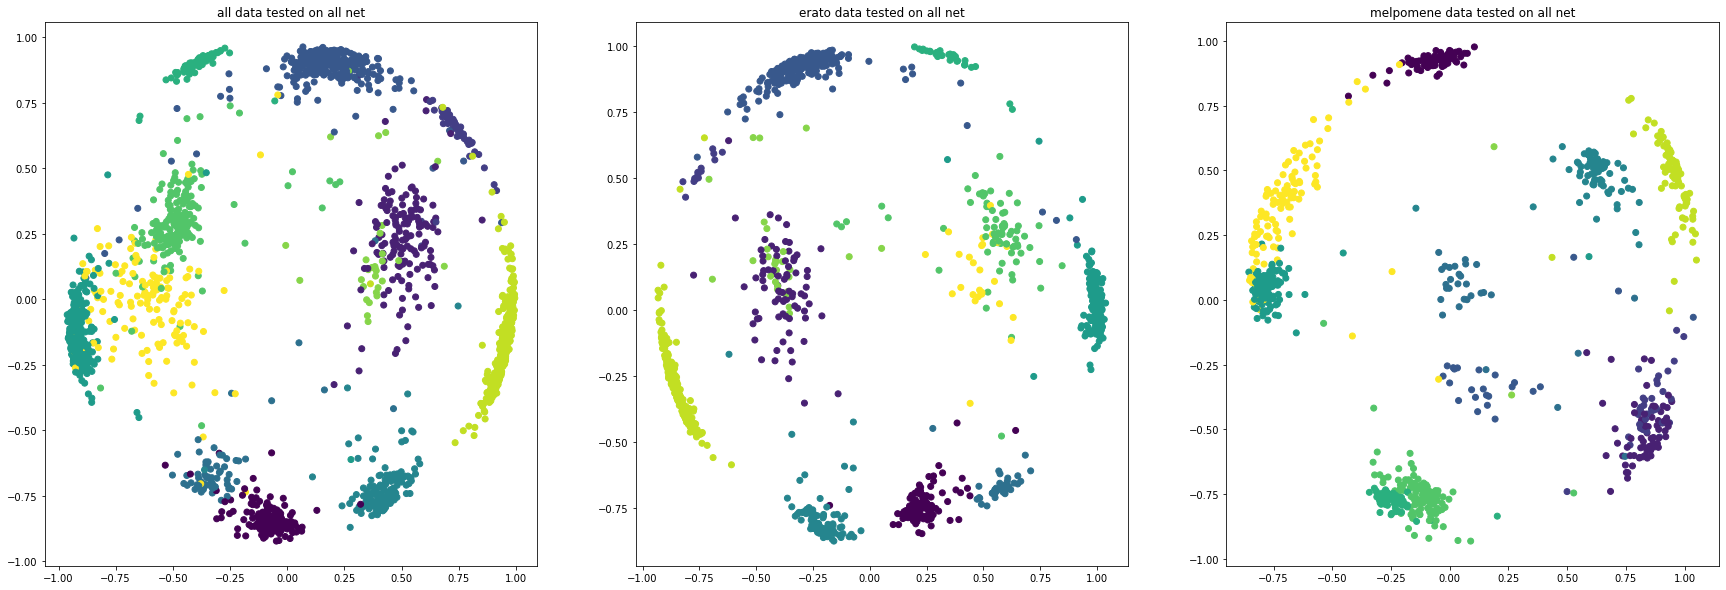

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
all_on_all_pembs, all_on_all_acc, all_on_all_test_labels, all_on_all_failures = test(all_net, all_data, all_labels, axs[0], "all data tested on all net", all)
e_on_all_pembs, e_on_all_acc, e_on_all_test_labels, e_on_all_failures = test(all_net, erato_data, erato_labels, axs[1], "erato data tested on all net", erato)
m_on_all_pembs, m_on_all_acc, m_on_all_test_labels, m_on_all_failures = test(all_net, melpomene_data, melpomene_labels, axs[2], "melpomene data tested on all net", melpomene)

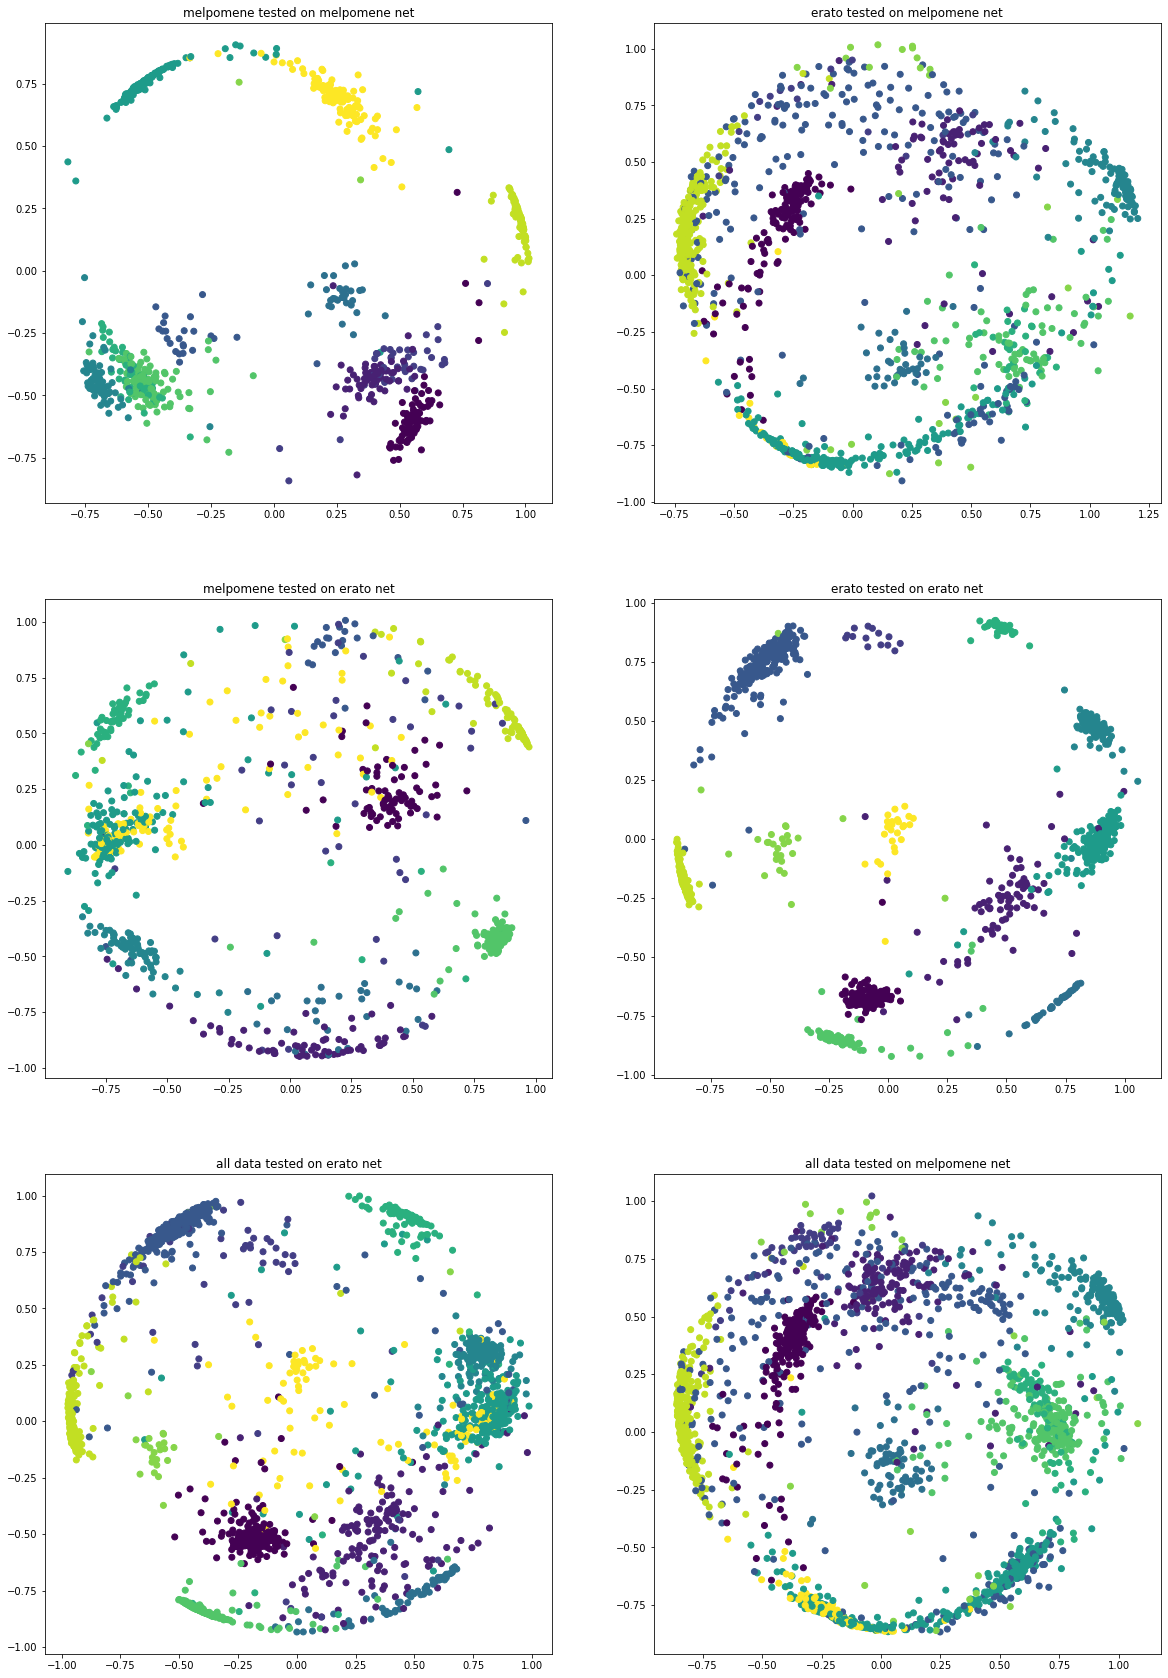

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 30))
m_on_m_pembs, m_on_m_acc, m_on_m_test_labels, m_on_m_failures = test(melpomene_net, melpomene_data, melpomene_labels, axs[0,0], "melpomene tested on melpomene net", melpomene)
e_on_m_pembs, e_on_m_acc, e_on_m_test_labels, e_on_m_failures = test(melpomene_net, erato_data, erato_labels, axs[0,1], "erato tested on melpomene net", erato)
m_on_e_pembs, m_on_e_acc, m_on_e_test_labels, m_on_e_failures = test(erato_net, melpomene_data, melpomene_labels, axs[1,0], "melpomene tested on erato net", melpomene)
e_on_e_pembs, e_on_e_acc, e_on_e_test_labels, e_on_e_failures = test(erato_net, erato_data, erato_labels, axs[1,1], "erato tested on erato net", erato)
all_on_e_pembs, all_on_e_acc, all_on_e_test_labels, all_on_e_failures = test(erato_net, all_data, all_labels, axs[2,0], "all data tested on erato net", all)
all_on_m_pembs, all_on_m_acc, all_on_m_test_labels, all_on_m_failures = test(melpomene_net, all_data, all_labels, axs[2,1], "all data tested on melpomene net", all)

In [ ]:
print('melpomene tested on melpomene accuracy: {}%'.format(int(m_on_m_acc*100)))
print('melpomene tested on erato accuracy: {}%'.format(int(m_on_e_acc*100)))
print('erato tested on erato accuracy: {}%'.format(int(e_on_e_acc*100)))
print('erato tested on melpomene accuracy: {}%'.format(int(e_on_m_acc*100)))
print('all data tested on erato accuracy: {}%'.format(int(all_on_e_acc*100)))
print('all data tested on melpomene accuracy: {}%'.format(int(all_on_m_acc*100)))
print('all tested on all net accuracy: {}%'.format(int(all_on_all_acc*100)))
print('erato data tested on all net accuracy: {}%'.format(int(e_on_all_acc*100)))
print('melpomene data tested on all net accuracy: {}%'.format(int(m_on_all_acc*100)))

melpomene tested on melpomene accuracy: 97%
melpomene tested on erato accuracy: 74%
erato tested on erato accuracy: 98%
erato tested on melpomene accuracy: 62%
all data tested on erato accuracy: 88%
all data tested on melpomene accuracy: 75%
all tested on all net accuracy: 96%
erato data tested on all net accuracy: 97%
melpomene data tested on all net accuracy: 94%


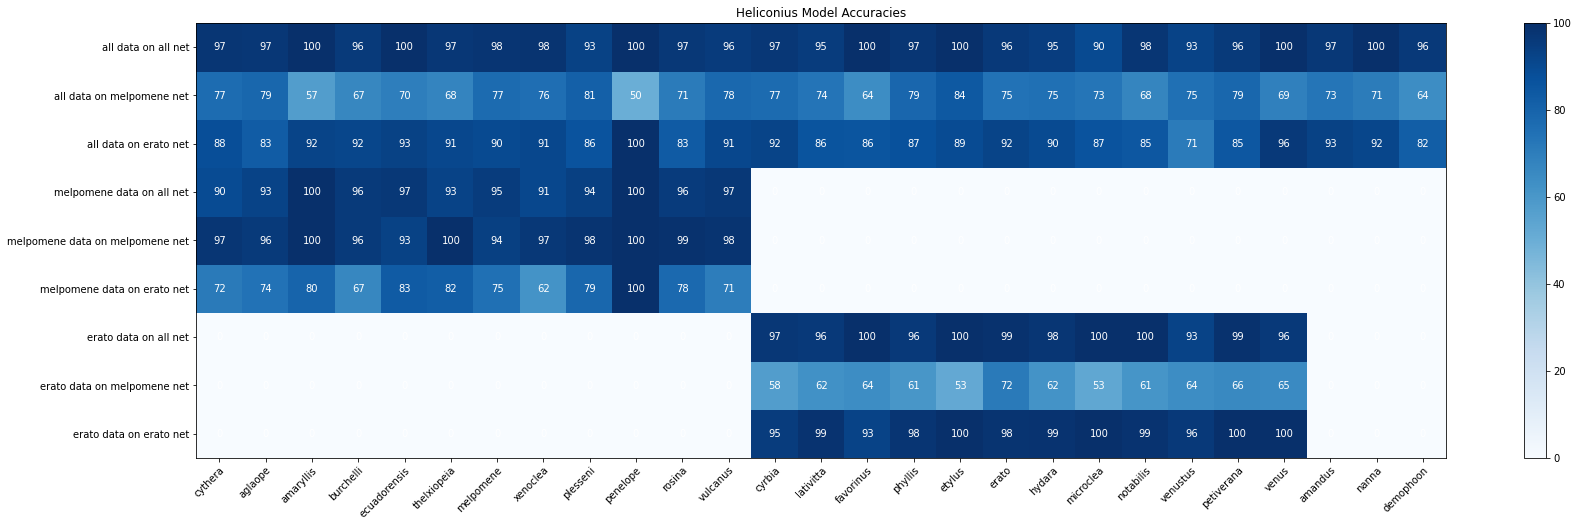

In [ ]:
fig, ax = plt.subplots(figsize=(28, 8))  
colorbar = ax.pcolormesh( heatmap_data , cmap = 'Blues' )
  
ax.set_title( 'Heliconius Model Accuracies' )
test = ['erato data on erato net', 'erato data on melpomene net', 'erato data on all net', 'melpomene data on erato net', 'melpomene data on melpomene net', 'melpomene data on all net', 'all data on erato net', 'all data on melpomene net', 'all data on all net']
ax.set_xticks(np.arange(len(all_subspecies))+0.5)
ax.set_xticklabels(all_subspecies)
ax.set_yticks(np.arange(len(test))+0.5)
ax.set_yticklabels(test)
labels = plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(len(test)):
    for j in range(len(all_subspecies)):
        text = ax.text(j+0.5, i+0.5, round(heatmap_data[i, j]),
                       ha="center", va="center", color="w")
plt.colorbar(colorbar)

In [ ]:
heatmap_data = np.array([make_list(e_on_e_failures), make_list(e_on_m_failures), make_list(e_on_all_failures), make_list(m_on_e_failures), make_list(m_on_m_failures), make_list(m_on_all_failures), make_list(all_on_e_failures), make_list(all_on_m_failures), make_list(all_on_all_failures)])

In [ ]:
def make_list(data) : 
  accs = []
  for subs in all_subspecies : 
    if subs in data : 
      accs.append(data[subs])
    else : 
      accs.append(0)
  return np.array(accs)

In [ ]:
all_subspecies = list(m_on_m_failures.keys()) + list(e_on_m_failures.keys())
all_subspecies += list(set(all_on_m_failures.keys()) - set(all_subspecies))

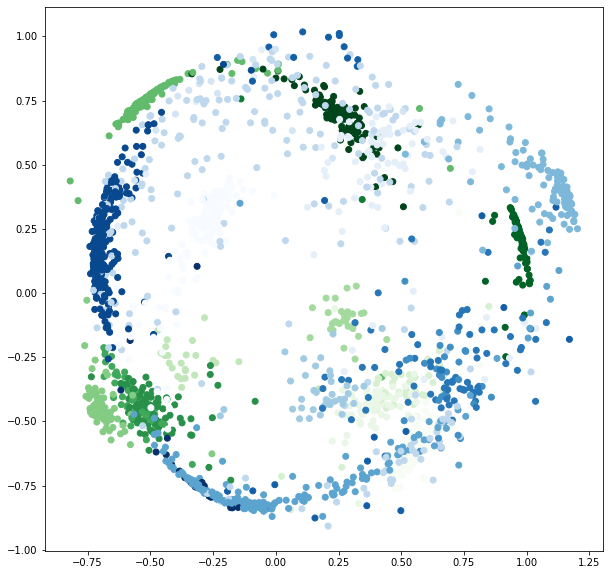

In [ ]:
evenly_spaced_interval = np.linspace(0, 1, 12)
blues = [cm.Blues(x) for x in evenly_spaced_interval]
erato_colors = [blues[i] for i in e_on_m_test_labels]
evenly_spaced_interval = np.linspace(0, 1, 12)
greens = [cm.Greens(x) for x in evenly_spaced_interval]
melpomene_colors = [greens[i] for i in m_on_m_test_labels]
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(m_on_m_pembs[:,0],m_on_m_pembs[:,1],c=melpomene_colors)
ax.scatter(e_on_m_pembs[:,0],e_on_m_pembs[:,1],c=erato_colors)

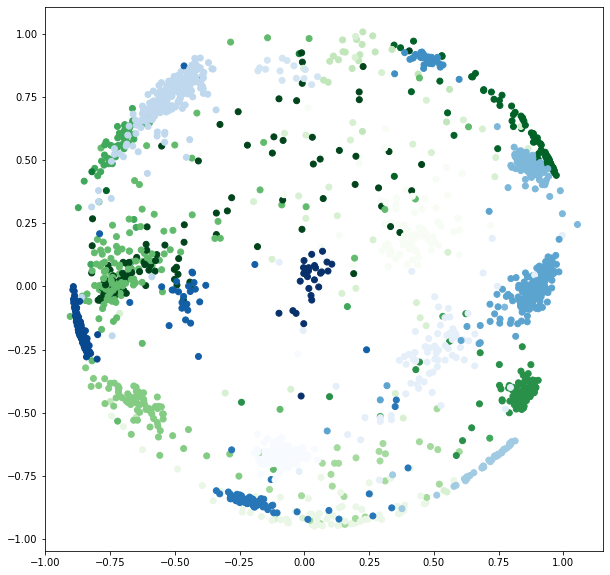

In [ ]:
evenly_spaced_interval = np.linspace(0, 1, 12)
blues = [cm.Blues(x) for x in evenly_spaced_interval]
erato_colors = [blues[i] for i in e_on_e_test_labels]
evenly_spaced_interval = np.linspace(0, 1, 12)
greens = [cm.Greens(x) for x in evenly_spaced_interval]
melpomene_colors = [greens[i] for i in m_on_e_test_labels]
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(m_on_e_pembs[:,0],m_on_e_pembs[:,1],c=melpomene_colors)
ax.scatter(e_on_e_pembs[:,0],e_on_e_pembs[:,1],c=erato_colors)

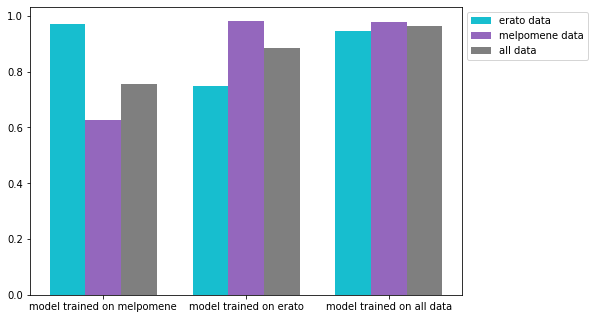

In [ ]:
data = [[m_on_m_acc, m_on_e_acc, m_on_all_acc], [e_on_m_acc, e_on_e_acc, e_on_all_acc], [all_on_m_acc, all_on_e_acc, all_on_all_acc]]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'tab:cyan', width = 0.25, label='erato data')
ax.bar(X + 0.25, data[1], color = 'tab:purple', width = 0.25, label='melpomene data')
ax.bar(X + 0.50, data[2], color = 'tab:gray', width = 0.25, label='all data')
ax.set_xticks(X+0.25)
ax.set_xticklabels( ('model trained on melpomene', 'model trained on erato', 'model trained on all data') )
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

In [ ]:
comimics = pd.read_csv('comimics.csv')
comimics = comimics.drop([13, 2, 9])
comimics = comimics.reset_index()
comimics = comimics.drop(columns=['index'])
labels = {}
for i in range(len(comimics)) : 
  name = comimics['Melpomene'][i] + '-' + comimics['Erato'][i]
  labels[i] = name
def get_rings() :
  rings = {}
  for i in range(len(comimics)) : 
    name = comimics['Melpomene'][i] + '-' + comimics['Erato'][i]
    rings[name] = 0  
  return rings

In [ ]:
def test_nonmimics(net, data, data_orig) : 
  net.eval()
  test_embs = []
  pca = PCA()
  predictions = {key : get_rings() for key in data_orig['Subspecies'].tolist()}
  for i in range(data.shape[0]):
    name = data_orig['Subspecies'][i]
    batch = tovar(data[i:i+1])
    z = net.get_embedding(batch)                
    p = net.predict(z).cpu().data.numpy()
    z = z.cpu().data.numpy()
    for zm in z:
      test_embs.append(zm.copy())
    label = np.argmax(p,axis=1)[0]
    predictions[name][labels[label]] += 1
  test_embs = np.array(test_embs)
  for sub in predictions : 
    summed = sum(list(predictions[sub].values()))
    for pred in predictions[sub] :
      predictions[sub][pred] = (predictions[sub][pred] / summed) * 100

  pembs = pca.fit_transform(test_embs)
  plt.scatter(pembs[:,0],pembs[:,1])
  return pembs, predictions

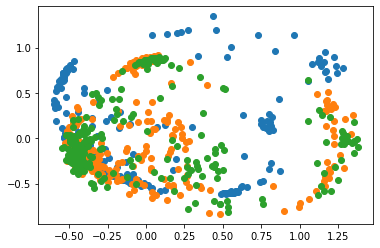

In [ ]:
nonmimics_pembs_enet, nonmimics_predictions_enet = test_nonmimics(erato_net, nonmimics_data, nonmimics)
nonmimics_pembs_mnet, nonmimics_predictions_mnet = test_nonmimics(melpomene_net, nonmimics_data, nonmimics)
nonmimics_pembs_anet, nonmimics_predictions_anet = test_nonmimics(all_net, nonmimics_data, nonmimics)

In [ ]:
def create_hist_mimics(nonmimics_predictions) : 
  hist_mimics = []
  nonmimic_names = sorted(list(nonmimics_predictions.keys()))
  for i in range(12): 
    mimic_list = []
    mimicry_ring = labels[i]
    for mimic in nonmimic_names : 
      elt = nonmimics_predictions[mimic][mimicry_ring]
      mimic_list.append(elt)
    hist_mimics.append(mimic_list) 
  return hist_mimics

In [ ]:
label_legend = []
for i in range(12) : 
  label_legend.append(labels[i])

In [ ]:
def plot_hist(ax, hist_mimics, legend, title) :
  X = np.arange(11)
  evenly_spaced_interval = np.linspace(0, 1, 13)
  colors = [cm.GnBu(x) for x in evenly_spaced_interval][1:]
  offsets = np.arange(-.5, .5, 12)
  bottom = None
  for i in range(12) : 
    color_index = len(colors) - i - 1
    ax.bar(X, hist_mimics[i], color = colors[color_index], width = 0.5, label=label_legend[i], bottom = bottom)
    if bottom is None : 
      bottom = np.array(hist_mimics[i])
    else : 
      bottom += np.array(hist_mimics[i])
  ax.set_xticks(X)
  ax.set_xticklabels(nonmimic_names)
  labels = plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
  if legend : 
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
  ax.set_title(title)

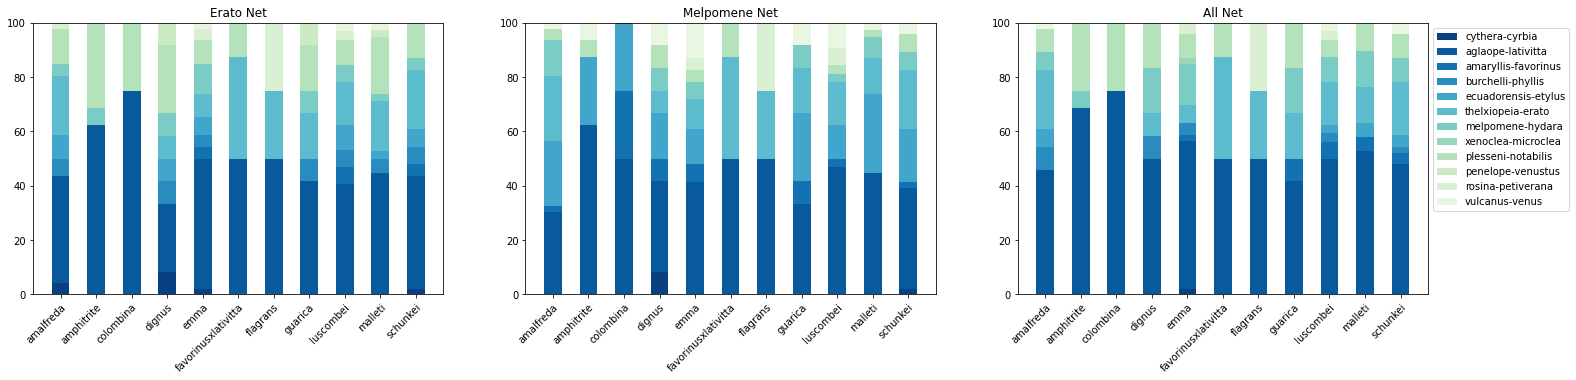

In [ ]:
hist_mimics_e = create_hist_mimics(nonmimics_predictions_enet)
hist_mimics_m = create_hist_mimics(nonmimics_predictions_mnet)
hist_mimics_a = create_hist_mimics(nonmimics_predictions_anet)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
plot_hist(ax[0], hist_mimics_e, False, 'Erato Net')
plot_hist(ax[1], hist_mimics_m, False, 'Melpomene Net')
plot_hist(ax[2], hist_mimics_a, True, 'All Net')

In [ ]:
bar_data = {}
for i in range(len(labels)) : 
  bar_data[labels[i]] = hist_mimics[i]

In [ ]:
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True) : 
  # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

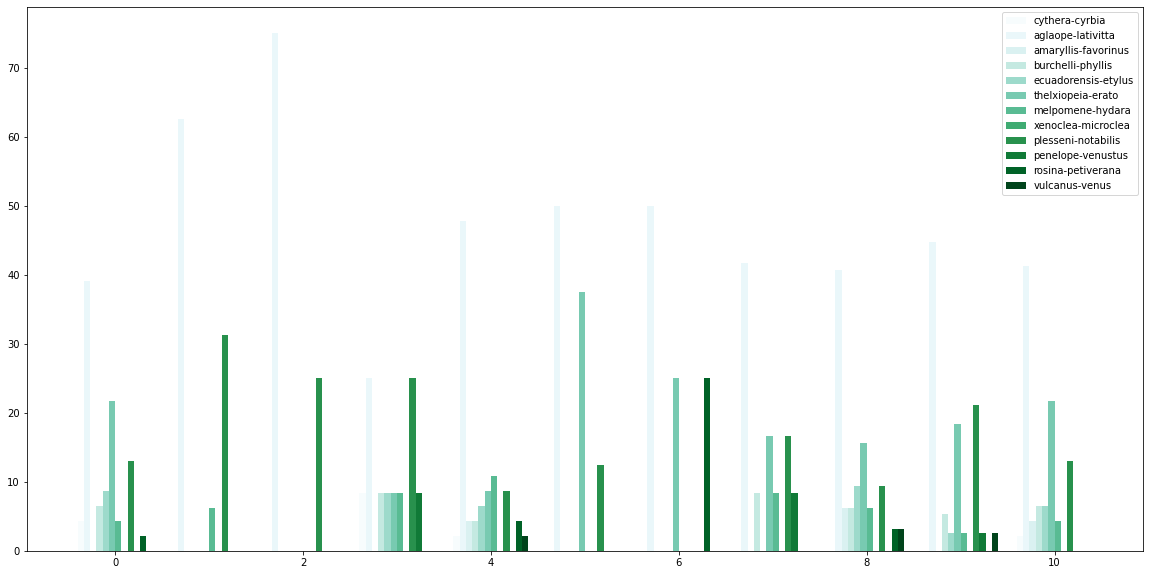

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
evenly_spaced_interval = np.linspace(0, 1, 12)
colors = [cm.BuGn(x) for x in evenly_spaced_interval]
bar_plot(ax, bar_data, colors)